In [1]:
using PyPlot, Interact

push!(LOAD_PATH, "../src/")
using HDStat

INFO: Loading help data...


### Numerical verification of AR-MP distribution

Options{:ToggleButtons,Int64}([Input{Int64}] 1000,"n",1000,"1000",["1000"=>1000,"2000"=>2000,"5000"=>5000])

Slider{Int64}([Input{Int64}] 2550,"p",2550,100:5000)

Slider{Float64}([Input{Float64}] 0.5,"ϕ",0.5,0.02:0.02:0.98)

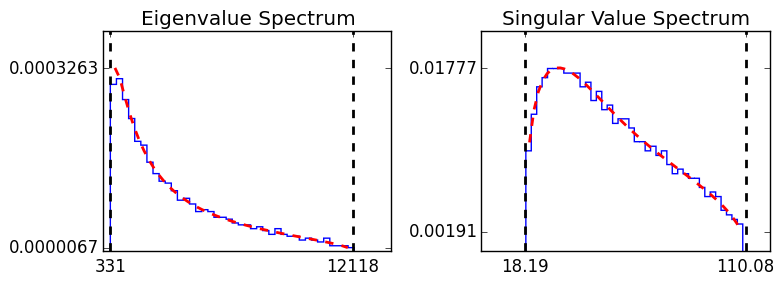

In [2]:
f = figure(figsize=(8, 3))
σ = 1.0

@manipulate for n = [1000, 2000, 5000], p = 100:5000, ϕ = 0.02:0.02:0.98
    m = ARMPModel(n, p, ϕ, σ)
        
    Ss = sv_rand(m)
    Su, Sl = sv_ub(m), sv_lb(m)
        
    Es = ev_rand(m)
    Eu, El = ev_ub(m), ev_lb(m)
        
    svspec, evspec = sv_spec(m), ev_spec(m)
        
    withfig(f) do
        x = ev_linsupport(m, 51)[2:end - 1]
        y = map(evspec, x)
        subplot(121)
        plt.hist(Es, normed=true, histtype="step", bins=40)
        plot(x, y, "r--", linewidth=2)
        axvline(El, linewidth=2, color="k", linestyle="--")
        axvline(Eu, linewidth=2, color="k", linestyle="--")
        xticks([El, Eu]); yticks([minimum(y), maximum(y)]); ylim([0, maximum(y) * 1.2]); title("Eigenvalue Spectrum")
            
        x = sv_linsupport(m, 51)[2:end - 1]
        y = map(svspec, x)
        subplot(122)
        plt.hist(Ss, normed=true, histtype="step", bins=40)
        plot(x, y, "r--", linewidth=2)
        axvline(Sl, linewidth=2, color="k", linestyle="--")
        axvline(Su, linewidth=2, color="k", linestyle="--")
        xticks([Sl, Su]); yticks([minimum(y), maximum(y)]); ylim([0, maximum(y) * 1.2]); title("Singular Value Spectrum")
        
        tight_layout()
    end
end

Options{:ToggleButtons,Int64}([Input{Int64}] 500,"n",500,"500",["500"=>500,"1000"=>1000,"2000"=>2000])

Slider{Int64}([Input{Int64}] 2550,"p",2550,100:5000)

Slider{Int64}([Input{Int64}] 3,"k",3,1:5)

Slider{Float64}([Input{Float64}] 0.5,"ϕ",0.5,0.02:0.02:0.98)

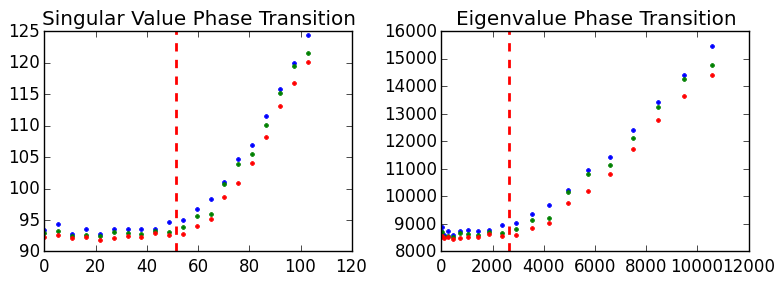

In [27]:
g = figure(figsize=(8, 3))
npt, σ = 20, 1.0

# cca(U, V) = sum(svd(U' * V)[2]) / size(U, 2)

@manipulate for n in [500, 1000, 2000], p = 100:5000, k = 1:5, ϕ = 0.02:0.02:0.98
    m = ARMPModel(n, p, ϕ, σ)
    
    sthresh = sv_infloor(m)
    ethresh = ev_infloor(m)
    sv_out = zeros(npt, k)
    ev_out = zeros(npt, k)
    sv_in = linspace(0, sthresh * 2, npt)
    for (ksv, sv) in enumerate(sv_in)
        U, V = qr(randn(n, k))[1], qr(randn(p, k))[1]
        X = rand(m) + sv * U * V'
        ev_out[ksv, :] = eigs(X * X'; nev=k)[1]
        sv_out[ksv, :] = sqrt(ev_out[ksv, :])
    end
    
#     sv_out_theory = map(x -> sv_xfer(m, x), sv_in)
#     ev_out_theory = map(x -> ev_xfer(m, x), sv_in.^2)
    
    withfig(g) do
        subplot(121)
        plot(sv_in, sv_out, ".")
#         plot(sv_in, sv_out_theory, "k-", linewidth=2)
        axvline(sthresh, color="r", linestyle="--", linewidth=2)
#         axhline(sv_xfer(m, sthresh), color="r", linestyle="--", linewidth=2)
        title("Singular Value Phase Transition")
        
        subplot(122)
        plot(sv_in.^2, ev_out, ".")
        axvline(ethresh, color="r", linestyle="--", linewidth=2)
        title("Eigenvalue Phase Transition")
#         subplot(222)
#         plot(sv_in.^2, ev_out, ".")
#         plot(sv_in.^2, ev_out_theory, "k-", linewidth=2)
#         axvline(sthresh^2, color="r", linestyle="--", linewidth=2)
#         axhline(sv_xfer(m, sthresh)^2, color="r", linestyle="--", linewidth=2)
#         title("Eigenvalue Phase Transition")
#         subplot(223)
#         plot(sv_in, left, ".")
#         plot(sv_in, left_theory, "r--", linewidth=2)
#         yticks([0, 1]); title("Left Singular Vector Overlap")
#         subplot(224)
#         plot(sv_in, right, ".")
#         plot(sv_in, right_theory, "r--", linewidth=2)
#         yticks([0, 1]); title("Right Singular Vector Overlap")
        tight_layout()
    end
end

### Limiting behavior (T / tau -> 0, N / T = c) of AR-MP compared against MP only

Comparison of the Marchenko-Pastur model and the AR MP model. For the AR model, we have $\phi = 1 - 1 / \tau$. For the MP model, we have $\sigma^2 = 1 / (1 - \phi^2)$. Maintaining the same aspect ratio ($p / n$) for the AR model, we ask what is the equivalent number of columns ($\alpha n$) in an MP model for the spectra of the two models to be similar?

In [28]:
tau = 2.0; phi = 1.0 - 1.0 / tau
sigma = 1 / sqrt(1 - phi^2)
c = 0.4;
println("tau: ", tau)
println("phi: ", phi)
println("sigma: ", sigma)
println("c: ", c)

tau: 2.0
phi: 0.5
sigma: 1.1547005383792517
c: 0.4


In [29]:
using Optim

nN = 5
Ns = logspace(2, 8, nN)
Ps = c * Ns
aUpper = zeros(nN)
aLower = zeros(nN)

for (kN, (n, p)) in enumerate(zip(Ns, Ps))
    armpModel = ARMPModel(int(p), int(n), phi, 1)
    armpLb, armpUp = ev_lb(armpModel), ev_ub(armpModel)
    
    eqLb(a) = (ev_lb(MPModel(int(p), int(a * n / tau), sigma)) - armpLb)^2
    eqUp(a) = (ev_ub(MPModel(int(p), int(a * n / tau), sigma)) - armpUp)^2
    
    aUpper[kN] = optimize(eqUp, 0.1, 500.0).minimum
    aLower[kN] = optimize(eqLb, 0.1, 500.0).minimum
end

upper: 3.199620609891795
lower: 1.7622072045956476


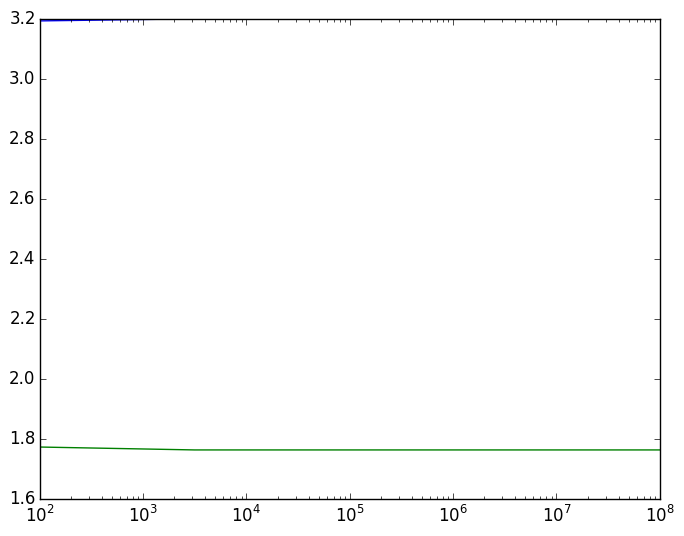

In [30]:
println("upper: ", aUpper[end])
println("lower: ", aLower[end])
plot(Ns, aUpper)
plot(Ns, aLower)
xscale("log")

In [31]:
n = 500; p = int(c * n);
nTrial = 2; nBin = 41;

armp_model = ARMPModel(p, n, phi, 1)
mp_model = MPModel(p, n, sigma)

MPModel(200,500,0.4,1.1547005383792517)

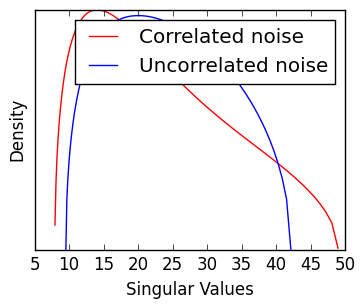

In [33]:
figure(figsize=(4, 3))

armpSpecSupport = sv_logsupport(armp_model, 101)
armpPDF = map(sv_spec(armp_model), armpSpecSupport)
plot(armpSpecSupport, armpPDF, "r")

mpSpecSupport = sv_logsupport(mp_model, 101)
mpPDF = map(sv_spec(mp_model), mpSpecSupport)
plot(mpSpecSupport, mpPDF, "b")

xlabel("Singular Values"); ylabel("Density")
yticks([])
legend(["Correlated noise", "Uncorrelated noise"])

savefig("../figures/noise.eps")

### Recovering low-dim dynamics

Fix $K, P / N$, take the limit $P, N \to \infty$. Where is the theoretically predicted gap? How does it related to the error in recovered eigenvalues?